In [1]:
# library(gtools)
# library(parallel)
# library(pbmcapply)
library(tidyverse)
library(Seurat)
library(data.table)
dotenv::load_dot_env()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [4]:
srobj = readRDS(Sys.getenv("FG13srobj"))
meta = read.table(Sys.getenv("FG13metafile"), sep="\t", header=1) %>% column_to_rownames('CellID')
srobj@meta.data = meta[colnames(srobj), ]

In [7]:
srobj = srobj[, !grepl("(Doub)|(LowQual)", srobj$type)]

In [8]:
pw.de.df <- read.table(Sys.getenv("FG_PW_DIFFEXP_TSV", sep="\t", header=1)

In [9]:
pw.de.df %>% dim

[1] 8278346       7

In [10]:
pw.de.df = separate(pw.de.df, "comparison_name", c("ident.1", 'ident.2'), sep = "__VS__", remove = FALSE)

In [11]:
pw.de.df.filt <- pw.de.df %>%
    group_by(comparison_name) %>% 
    filter(p_val_adj < 0.01) %>% 
    top_n(50, p_val_adj)

In [12]:
pw.de.df.filt %>% dim

[1] 826898      9

In [13]:
length(unique(pw.de.df.filt$gene))

[1] 4445

In [18]:
genes.use = as.character(unique(pw.de.df.filt$gene))
genes.use %>% head

[1] "IGLC2"   "IGKC"    "IGLC3"   "DNAJC7"  "PIM2"    "SH3KBP1"

In [16]:
srobj <- ScaleData(srobj, features = genes.use)

Centering and scaling data matrix



# Dendrogram

In [19]:
# calculate cluster centers
scaled.data = srobj@assays$SCT@scale.data[as.character(genes.use), ]
scaled.data.t = t(scaled.data)
scaled.data.t = as.data.frame(scaled.data.t)
scaled.data.t$cellsubsets = srobj$curatedname

agg.clst.cntrs = aggregate(scaled.data.t[, -which(colnames(scaled.data.t) == "cellsubsets")],
          list(scaled.data.t$cellsubsets), median)
colnames(agg.clst.cntrs) <- c("cellsubsets", colnames(agg.clst.cntrs)[2:length(colnames(agg.clst.cntrs))])

In [20]:
agg.clst.cntrs %>% dim

[1]  137 4446

In [21]:
agg.clst.cntrs[1:5, 1:5]

,cellsubsets,IGLC2,IGKC,IGLC3,DNAJC7
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,FG.B.BASP1.ACTG1,-0.5274709,-0.131899767,-0.4202076,-0.3643104
2,FG.B.CXCR4.PABPC1,-0.5274709,0.005384196,-0.4202076,-0.3643104
3,FG.B.IGHD.FCER2,-0.5274709,0.117553361,-0.4202076,-0.3643104
4,FG.B.IGLC6.IGLC7,0.4060376,-0.558342705,0.6817470,-0.3643104
5,FG.B.TNFRSF13B.GPR183,-0.5274709,0.117553361,-0.4202076,-0.3643104


In [22]:
any(is.na(agg.clst.cntrs))

[1] FALSE

In [23]:
clst.cntrs <- agg.clst.cntrs %>% 
    column_to_rownames("cellsubsets") %>%
    t %>% as.data.frame

In [24]:
clst.cntrs[1:5, 1:5]

,FG.B.BASP1.ACTG1,FG.B.CXCR4.PABPC1,FG.B.IGHD.FCER2,FG.B.IGLC6.IGLC7,FG.B.TNFRSF13B.GPR183
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IGLC2,-0.5274709,-0.527470858,-0.5274709,0.4060376,-0.5274709
IGKC,-0.1318998,0.005384196,0.1175534,-0.5583427,0.1175534
IGLC3,-0.4202076,-0.420207609,-0.4202076,0.6817470,-0.4202076
DNAJC7,-0.3643104,-0.364310422,-0.3643104,-0.3643104,-0.3643104
PIM2,-0.4192968,-0.419296791,-0.4192968,-0.4192968,-0.4192968


In [25]:
clst.cntrs %>%
    rownames_to_column("GeneID") %>%
    write.table(file=Sys.getenv("FG_DEND_CLUST_CNTRS_TSV"), sep="\t", row.names=F)

# restore cluster centers

In [26]:
# install.packages("pvclust")
library(pvclust)

In [27]:
clst.cntrs <- read.table(file=Sys.getenv("FG_DEND_CLUST_CNTRS_TSV"), sep="\t", header=1) %>%
    column_to_rownames("GeneID")

In [29]:
result <- pvclust(clst.cntrs, method.dist="cor", method.hclust="complete", nboot=100, parallel=TRUE)

Creating a temporary cluster...done:
socket cluster with 31 nodes on host ‘localhost’
Multiscale bootstrap... Done.


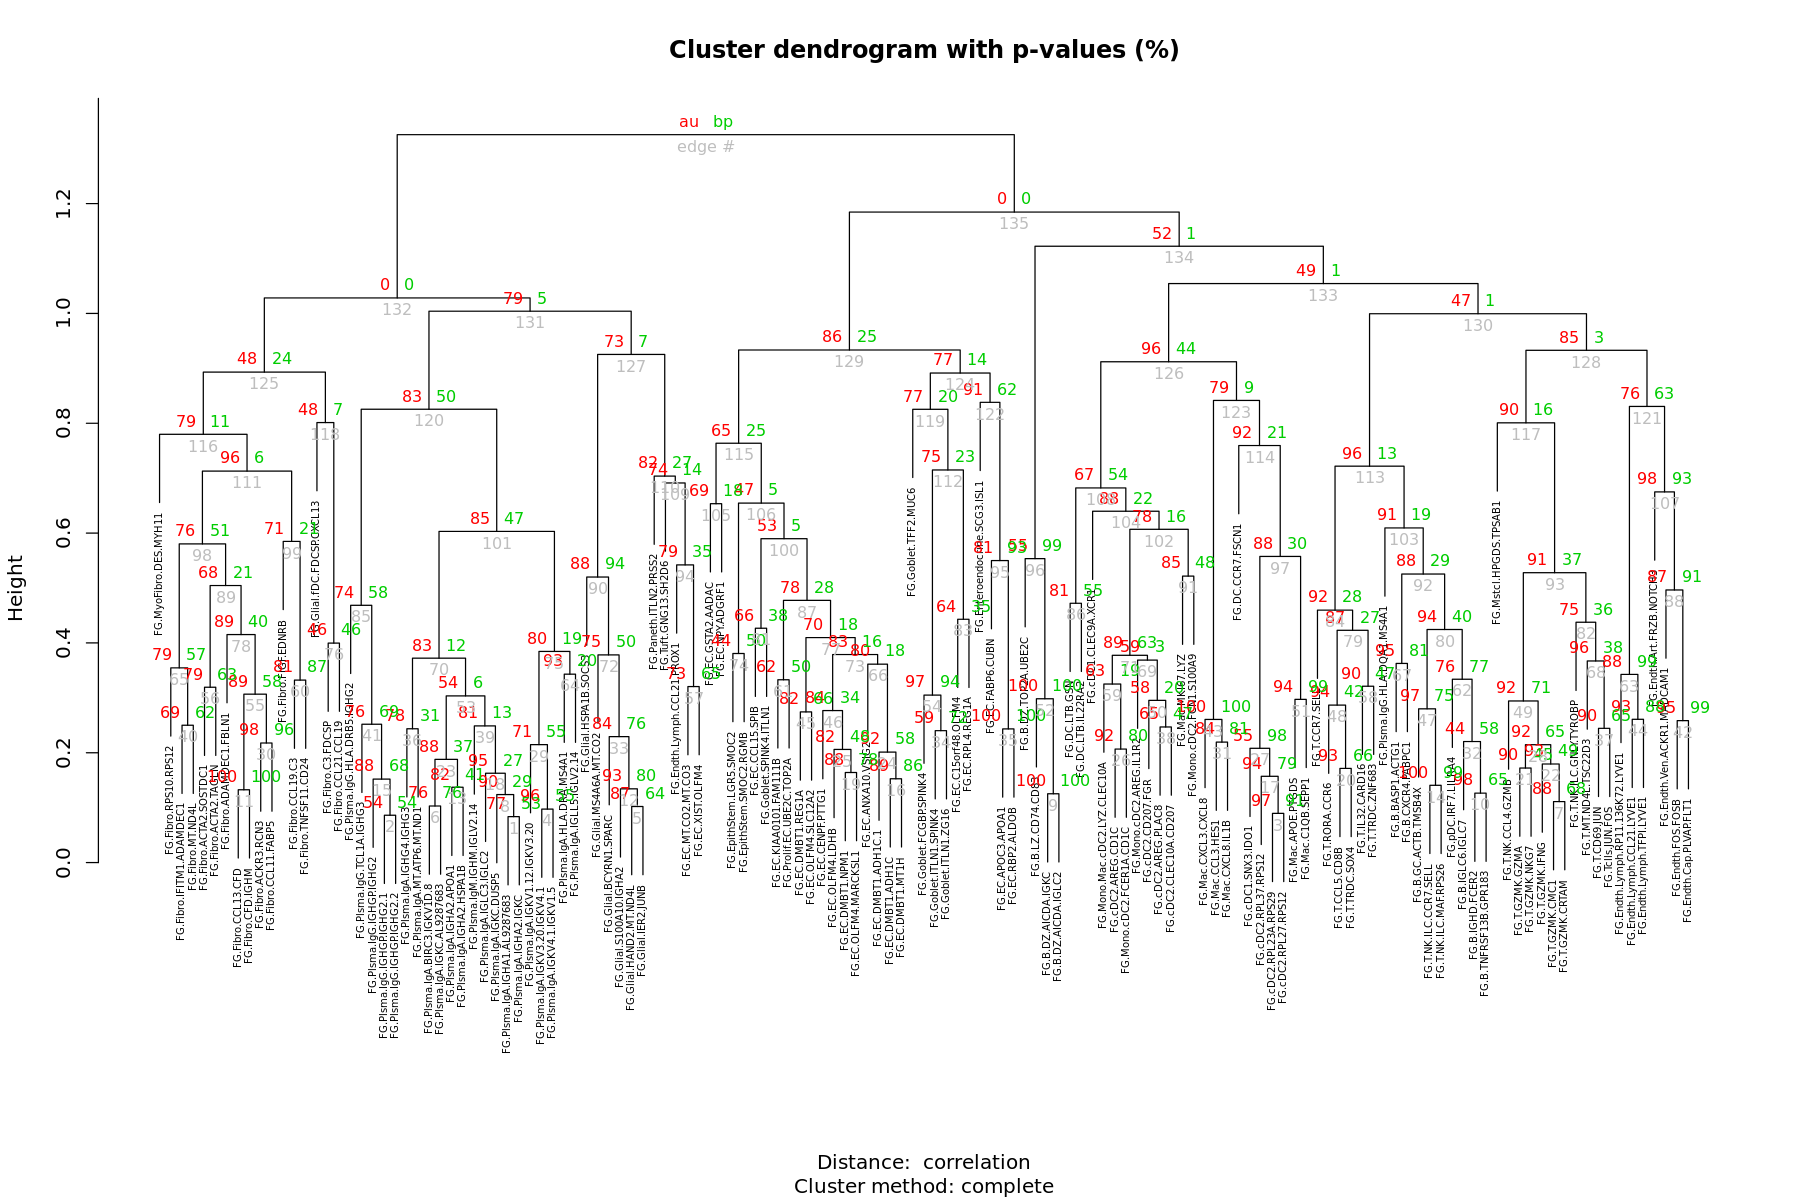

In [30]:
options(repr.plot.height = 10, repr.plot.width = 15)
plot(result, cex = .5)

In [31]:
saveRDS(result, Sys.getenv("FG_FULL_DEND_SROBJ"))

In [ ]:
# options(repr.plot.height = 20, repr.plot.width = 20)
# purpleyellow <- colorRampPalette(c('purple', 'black', 'yellow'))(n=100)
# pheatmap(cor(clst.cntrs),
#          fontsize=4,
#          border_color = NA,
#          labels_row = str_replace_all(colnames(clst.cntrs), "−", "-"),
#          labels_col = str_replace_all(colnames(clst.cntrs), "−", "-"),
#          color = purpleyellow,
#          height = 20, width = 20,
#          filename = "~/plots/FGID13/clusterCenterHeatmap.pdf"
# )    

# Plot Dendro

In [32]:
# install.packages("ggdendro")
library(ggdendro)

In [33]:
table(srobj$patient)


 p009  p017  p023  p028  p030  p033  p034  p035  p037  p043  p044  p049  p050 
10552  4391 10666  9885  8963  9105  7695  5189  3753  3321 11983  4512  4436 

In [ ]:
gsub("Hs\\.", "", srobj$tier1name[match(ddata_L$label, make.names(srobj$curatedname))]);

In [57]:
ddata_L$label

[1] FG.MyoFibro.DES.MYH11            FG.Fibro.RPS10.RPS12            
  [3] FG.Fibro.IFITM1.ADAMDEC1         FG.Fibro.MT.ND4L                
  [5] FG.Fibro.ACTA2.SOSTDC1           FG.Fibro.ACTA2.TAGLN            
  [7] FG.Fibro.ADAMDEC1.FBLN1          FG.Fibro.CCL13.CFD              
  [9] FG.Fibro.CFD.IGHM                FG.Fibro.ACKR3.RCN3             
 [11] FG.Fibro.CCL11.FABP5             FG.Fibro.FIGF.EDNRB             
 [13] FG.Fibro.CCL19.C3                FG.Fibro.TNFSF11.CD24           
 [15] FG.Glial.fDC.FDCSP.CXCL13        FG.Fibro.C3.FDCSP               
 [17] FG.Fibro.CCL21.CCL19             FG.Plsma.IgG.HLA.DRB5.IGHG2     
 [19] FG.Plsma.IgG.TCL1A.IGHG3         FG.Plsma.IgG.IGHGP.IGHG2        
 [21] FG.Plsma.IgG.IGHGP.IGHG2.1       FG.Plsma.IgG.IGHGP.IGHG2.2      
 [23] FG.Plsma.IgA.IGHG4.IGHG3         FG.Plsma.IgA.MT.ATP6.MT.ND1     
 [25] FG.Plsma.IgA.BIRC3.IGKV1D.8      FG.Plsma.IgA.IGKC.AL9287683     
 [27] FG.Plsma.IgA.IGHA2.APOA1         FG.Plsma.IgA.IGHA2.HSPA1B       
 [29] FG.Plsma.IgM.IGHM.IGLV2.14       FG.Plsma.IgA.IGLC3.IGLC2        
 [31] FG.Plsma.IgA.IGKC.DUSP5          FG.Plsma.IgA.IGHA1.AL9287683    
 [33] FG.Plsma.IgA.IGHA2.IGKC          FG.Plsma.IgA.IGKV1.12.IGKV3.20  
 [35] FG.Plsma.IgA.IGKV3.20.IGKV4.1    FG.Plsma.IgA.IGKV4.1.IGKV1.5    
 [37] FG.Plsma.IgA.HLA.DRA.MS4A1       FG.Plsma.IgA.IGLL5.IGLV2.14     
 [39] FG.Glial.HSPA1B.SOCS3            FG.Glial.MS4A6A.MT.CO2          
 [41] FG.Glial.BCYRN1.SPARC            FG.Glial.S100A10.IGHA2          
 [43] FG.Glial.HAND2.MT.ND4L           FG.Glial.IER2.JUNB              
 [45] FG.Paneth.ITLN2.PRSS2            FG.Tuft.GNG13.SH2D6             
 [47] FG.Endth.Lymph.CCL21.PROX1       FG.EC.MT.CO2.MT.CO3             
 [49] FG.EC.XIST.OLFM4                 FG.EC.GSTA2.AADAC               
 [51] FG.EC.NPY.ADGRF1                 FG.EpithStem.LGR5.SMOC2         
 [53] FG.EpithStem.SMOC2.RGMB          FG.EC.CCL15.SPIB                
 [55] FG.Goblet.SPINK4.ITLN1           FG.EC.KIAA0101.FAM111B          
 [57] FG.Prolif.EC.UBE2C.TOP2A         FG.EC.DMBT1.REG1A               
 [59] FG.EC.OLFM4.SLC12A2              FG.EC.CENPF.PTTG1               
 [61] FG.EC.OLFM4.LDHB                 FG.EC.DMBT1.NPM1                
 [63] FG.EC.OLFM4.MARCKSL1             FG.EC.ANXA10.VSIG2              
 [65] FG.EC.DMBT1.ADH1C.1              FG.EC.DMBT1.ADH1C               
 [67] FG.EC.DMBT1.MT1H                 FG.Goblet.TFF2.MUC6             
 [69] FG.Goblet.FCGBP.SPINK4           FG.Goblet.ITLN1.SPINK4          
 [71] FG.Goblet.ITLN1.ZG16             FG.EC.C15orf48.OLFM4            
 [73] FG.EC.RPL4.REG1A                 FG.Enteroendocrine.SCG3.ISL1    
 [75] FG.EC.FABP6.CUBN                 FG.EC.APOC3.APOA1               
 [77] FG.EC.RBP2.ALDOB                 FG.B.DZ.TOP2A.UBE2C             
 [79] FG.B.LZ.CD74.CD83                FG.B.DZ.AICDA.IGKC              
 [81] FG.B.DZ.AICDA.IGLC2              FG.DC.LTB.GSN                   
 [83] FG.DC.LTB.IL22RA2                FG.cDC1.CLEC9A.XCR1             
 [85] FG.Mono.Mac.cDC2.LYZ.CLEC10A     FG.cDC2.AREG.CD1C               
 [87] FG.Mono.cDC2.FCER1A.CD1C         FG.Mono.cDC2.AREG.IL1R2         
 [89] FG.cDC2.CD207.FGR                FG.cDC2.AREG.PLAC8              
 [91] FG.cDC2.CLEC10A.CD207            FG.Mac.MKI67.LYZ                
 [93] FG.Mono.cDC2.FCN1.S100A9         FG.Mac.CXCL3.CXCL8              
 [95] FG.Mac.CCL3.HES1                 FG.Mac.CXCL8.IL1B               
 [97] FG.DC.CCR7.FSCN1                 FG.cDC1.SNX3.IDO1               
 [99] FG.cDC2.RPL37.RPS12              FG.cDC2.RPL23A.RPS29            
[101] FG.cDC2.RPL27.RPS12              FG.Mac.APOE.PTGDS               
[103] FG.Mac.C1QB.SEPP1                FG.T.CCR7.SELL                  
[105] FG.T.RORA.CCR6                   FG.T.CCL5.CD8B                  
[107] FG.T.TRDC.SOX4                   FG.T.IL32.CARD16                
[109] FG.T.TRDC.ZNF683                 FG.Plsma.IgG.HLA.DQA1.MS4A1     
[111] FG.B.BASP1.ACTG1                 FG.

In [61]:
dd.row <- as.dendrogram(result$hclust)
ddata_x <- dendro_data(dd.row)
ddata_L <- label(ddata_x)
# ddata_L$label <- str_replace_all(ddata_L$label, "−", "-")
ddata_L$label = srobj$curatedname[match(ddata_L$label, make.names(srobj$curatedname))]
ddata_L$group <- gsub("Hs\\.", "", srobj$tier1name[match(ddata_L$label, srobj$curatedname)])

ddata_L$count = as.numeric(table(factor(srobj$curatedname))[result$hclust$order])

ddata_L$diversity = srobj@meta.data %>% 
    group_by(curatedname) %>%
    summarize(diversity = 1 - sum(((table(patient)) / (length(patient)))^2)) %>%
    .[result$hclust$order, ] %>%
    .[["diversity"]]

celltype.colors <- c(Epith = '#3BA63B', Fibro = '#D62728', Glial = '#A07AC4',
                Endth = '#FF9B45', Mloid = '#8C564B', Mstcl = '#E586C8',
                Tclls = '#1ABECF', Bclls = '#1F77B4', IGA_IGL_Plsma= '#7F7F7F',
                IGA_IGK_Plsma = '#7F7F7F', IGG_Plsma_Bcll= '#3F3F3F', IGM_Plsma= '#BFBFBF')

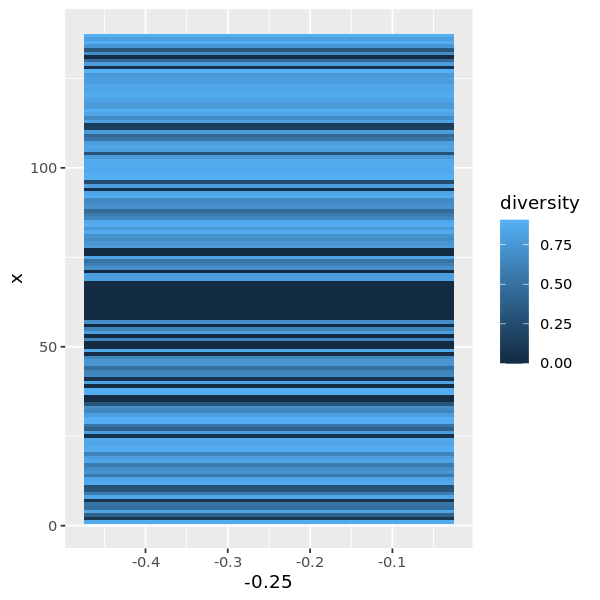

In [62]:
options(repr.plot.height = 5, repr.plot.width = 5)
ggplot(ddata_L) + geom_tile(aes(x = x, y=-0.25,fill=diversity), height=0.45) + coord_flip()

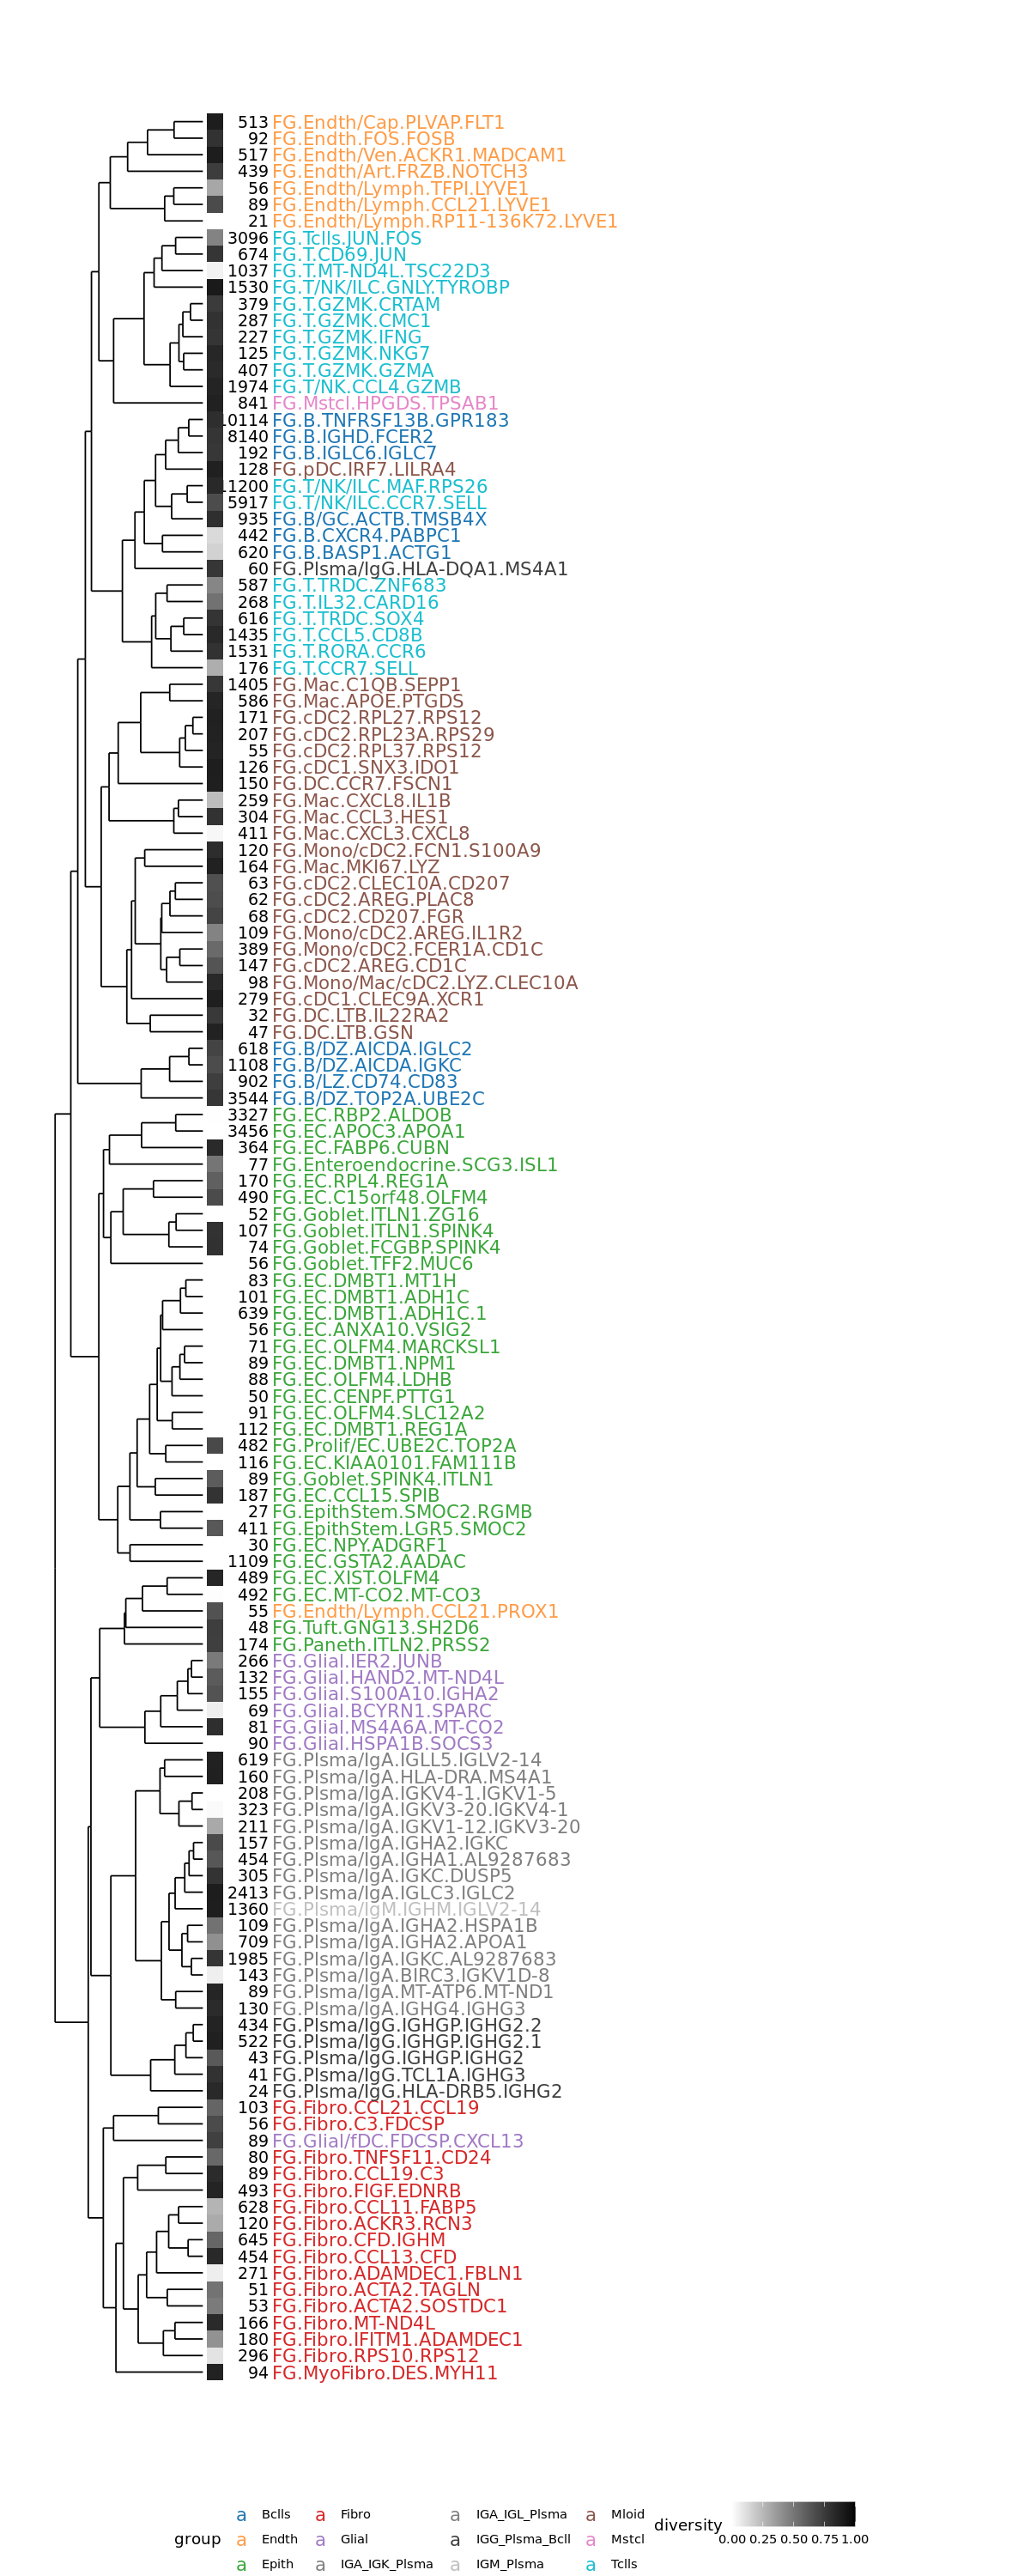

In [68]:
options(repr.plot.height = 25, repr.plot.width = 10)

scale.factor.x = 1

ggplot(segment(ddata_x)) +
  geom_segment(aes(x=x*scale.factor.x, y=y, xend=xend*scale.factor.x, yend=yend)) + 
  geom_text(data=ddata_L, angle = 0, hjust = 0, size = 4.5,
            aes(label=label, x=x*scale.factor.x, y=-0.62, color=group)) + 
  geom_text(data=ddata_L, angle = 0, hjust = 1, size = 4,
            aes(label=count, x=x*scale.factor.x, y=-0.59),color="black") +
  geom_tile(data=ddata_L, aes(x = x*scale.factor.x, y=-0.11, fill=diversity), height=0.15) +
  scale_color_manual(values=celltype.colors) +
  scale_fill_gradient(low = "white", high = "black", limits=c(0,1)) +
  coord_flip(clip = 'off') + 
  scale_y_reverse(limits = c(1.4, -7),
                 breaks = c(1, 0.75, 0.5, 0.25, 0),
                 labels = c(1, 0.75, 0.5, 0.25, 0)) +
#   scale_y_continuous(limits = c(-1,1)) +
  theme_void() + 
  theme(legend.position="bottom")

In [70]:
ggsave(filepath(Sys.getenv("FIGDIR"), "fg13atlas", "FG13_curatedname_vertical_dendrogram.pdf"),
       height = 25, width = 10, useDingbats=FALSE)